In [31]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# 1. Daten laden
file_path = "../data/processed/charging_sessions_cleaned.csv"
data = pd.read_csv(file_path, parse_dates=["connectionTime", "disconnectTime", "doneChargingTime"])

# 2. Feature-Engineering
# Berechnung der durchschnittlichen Ladeleistung
data['averageChargingPower'] = data['kWhDelivered'] / (
        (data['disconnectTime'] - data['connectionTime']).dt.total_seconds() / 3600
)

# Standortauslastung berechnen
data['connectionStart'] = data['connectionTime'].dt.floor('min')
data['connectionEnd'] = data['disconnectTime'].dt.floor('min')
occupancy = []
for index, row in data.iterrows():
    count = data[
        (data['siteID'] == row['siteID']) &
        (data['connectionTime'] <= row['disconnectTime']) &
        (data['disconnectTime'] >= row['connectionTime'])
        ].shape[0]
    occupancy.append(count)
data['siteOccupancy'] = occupancy

# Nur notwendige Spalten und keine NaN-Werte
data = data[['connectionTime', 'siteID', 'averageChargingPower', 'siteOccupancy']].dropna()

# Zeitreihenanalyse für SiteID=1 und SiteID=2
for site in [1, 2]:
    print(f"\nAnalyse für SiteID={site}")
    site_data = data[data['siteID'] == site]

    # Zeitreihe: Durchschnittliche Ladeleistung pro Stunde
    ts = site_data.resample('H', on='connectionTime')['averageChargingPower'].mean()
    ts = ts.dropna()  # Fehlende Werte entfernen

    # Sicherstellen, dass die Zeitreihe eine klare Frequenz hat
    ts = ts.asfreq('H')

    # ARIMA Modell erstellen und trainieren
    try:
        model = ARIMA(ts, order=(2, 1, 0))
        results_AR = model.fit()

        # Vorhersagen
        y_pred = results_AR.fittedvalues

        # Fehlerberechnung (RSS)
        rss = sum((y_pred - ts) ** 2)
        print(f"RSS für averageChargingPower (SiteID={site}): {rss:.4f}")

        # Zeitreihe in 3-Monats-Abschnitte teilen und plotten
        start_date = ts.index.min()
        end_date = ts.index.max()
        current_date = start_date

        while current_date < end_date:
            next_date = current_date + pd.DateOffset(months=3)

            ts_subset = ts[current_date:next_date]
            y_pred_subset = y_pred[current_date:next_date]

            plt.figure(figsize=(12, 6))
            plt.plot(ts_subset, label="Tatsächlich", color="blue", alpha=0.7)
            plt.plot(y_pred_subset, label="Vorhergesagt", color="red", alpha=0.7)
            plt.title(
                f"ARIMA: Tatsächlich vs. Vorhergesagt (SiteID={site}, {current_date.date()} - {next_date.date()})")
            plt.xlabel("Zeit")
            plt.ylabel("Durchschnittliche Ladeleistung (kW)")

            # X-Achse in 7-Tages-Intervallen beschriften
            ticks = ts_subset.index[::7 * 24]  # 7-Tages-Schritte, 24 Stunden pro Tag
            tick_labels = [date.strftime('%b %d') for date in ticks]
            plt.xticks(ticks, tick_labels, rotation=45)

            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

            current_date = next_date

    except Exception as e:
        print(f"Fehler beim ARIMA-Modell für SiteID={site}: {e}")


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x000002571A6A9810>>
Traceback (most recent call last):
  File "C:\Users\tobia\Documents\GitHub\AnalyticsandApplications\AAEnergizer\venv\Lib\site-packages\ipykernel\ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


KeyboardInterrupt: 

C:\Users\tobia\AppData\Local\Temp\ipykernel_31180\3900583066.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ts = site_data.resample('H', on='connectionTime')['averageChargingPower'].mean()
C:\Users\tobia\AppData\Local\Temp\ipykernel_31180\3900583066.py:28: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ts = ts.asfreq('H')


Warnung: Zeitreihe enthält 18310 NaN-Werte. Interpolation wird durchgeführt.
RSS für averageChargingPower (SiteID=1): 20149.9812


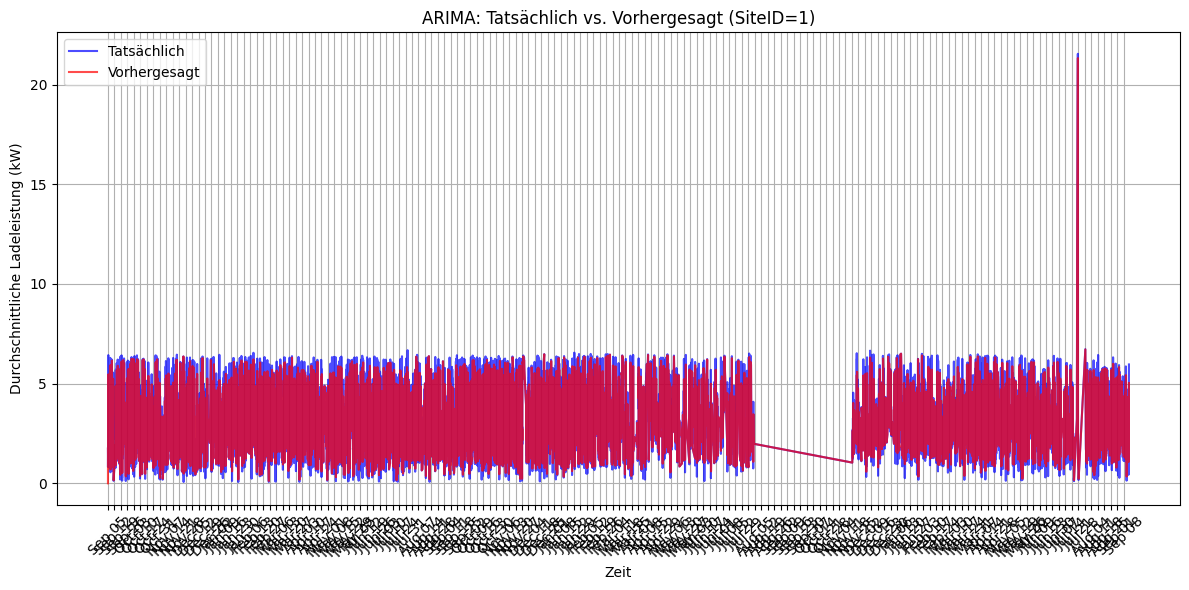


Analyse für SiteID=1


C:\Users\tobia\AppData\Local\Temp\ipykernel_31180\73915192.py:72: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ts = site_data.resample('H', on='connectionTime')['averageChargingPower'].mean()
C:\Users\tobia\AppData\Local\Temp\ipykernel_31180\73915192.py:78: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ts = ts.asfreq('H')
C:\Users\tobia\Documents\GitHub\AnalyticsandApplications\AAEnergizer\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\tobia\Documents\GitHub\AnalyticsandApplications\AAEnergizer\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecast

Durchschnittlicher Fehler für SiteID=1: 4.2978
RSS für averageChargingPower (SiteID=1): nan


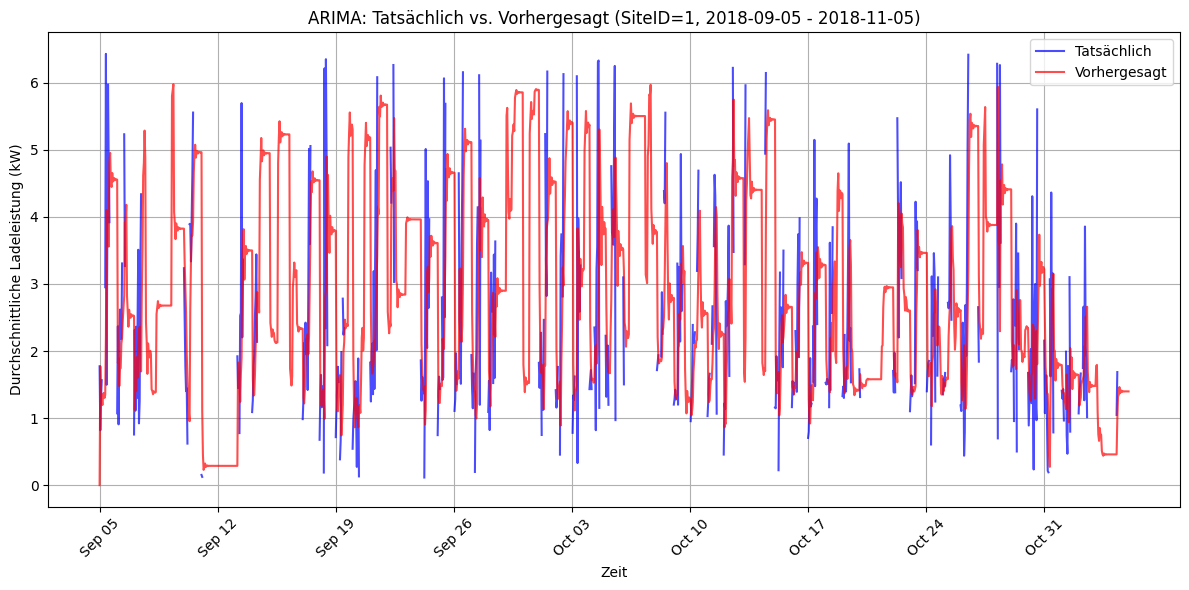

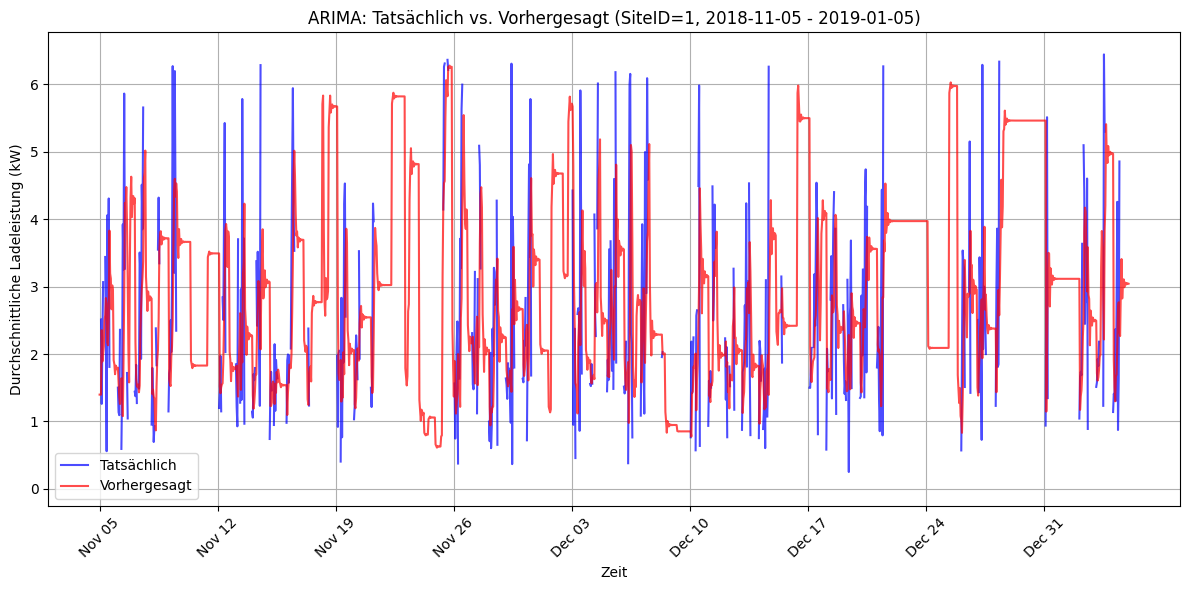

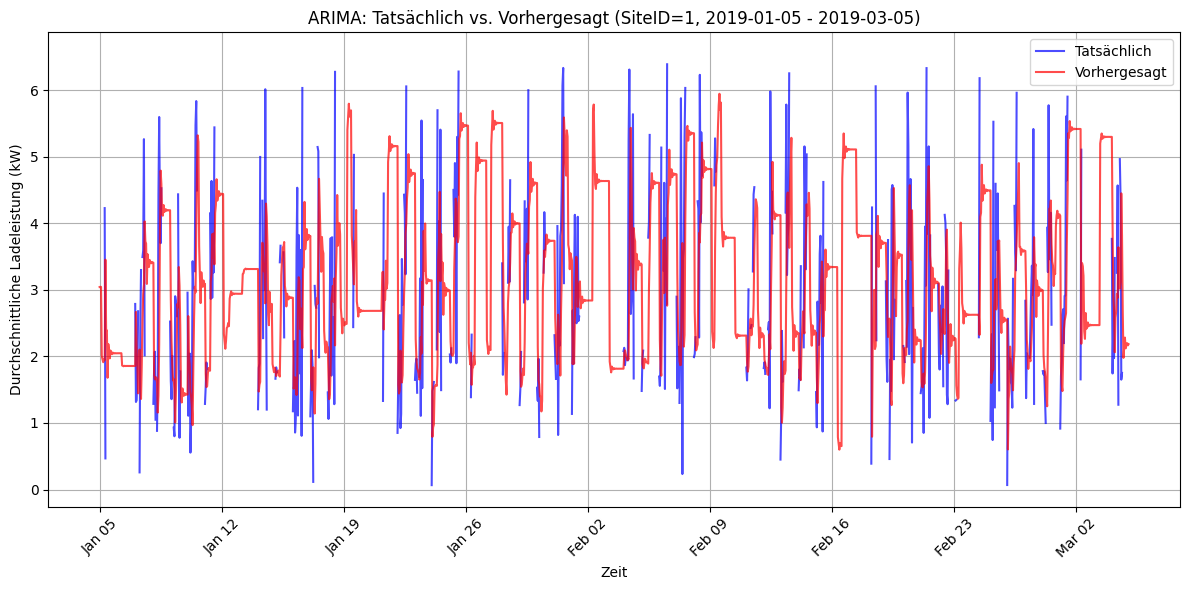

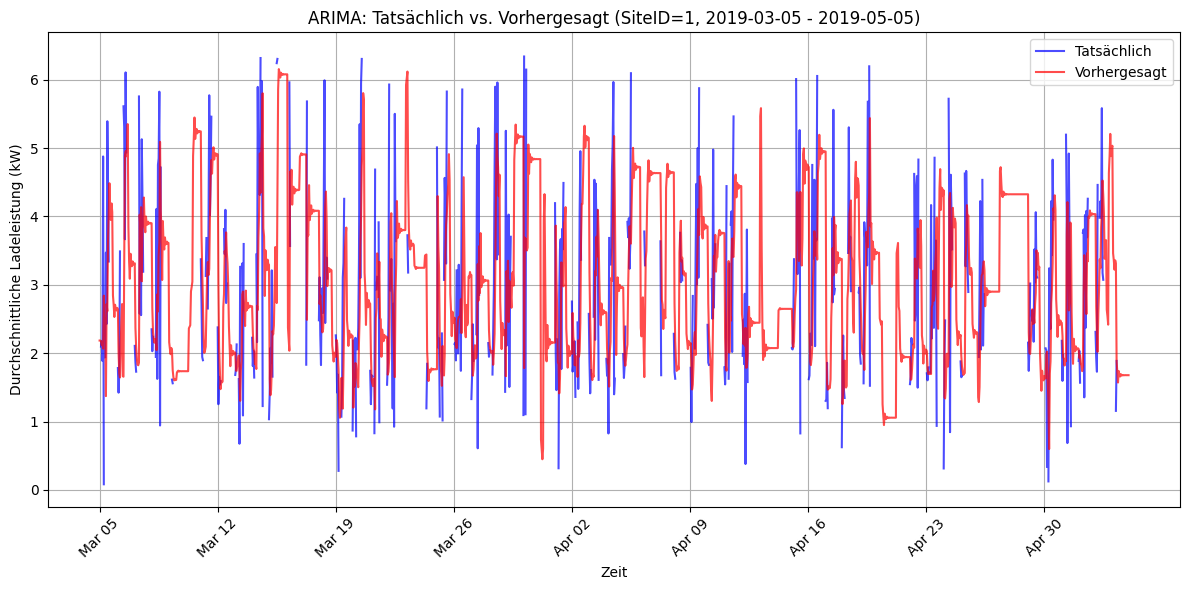

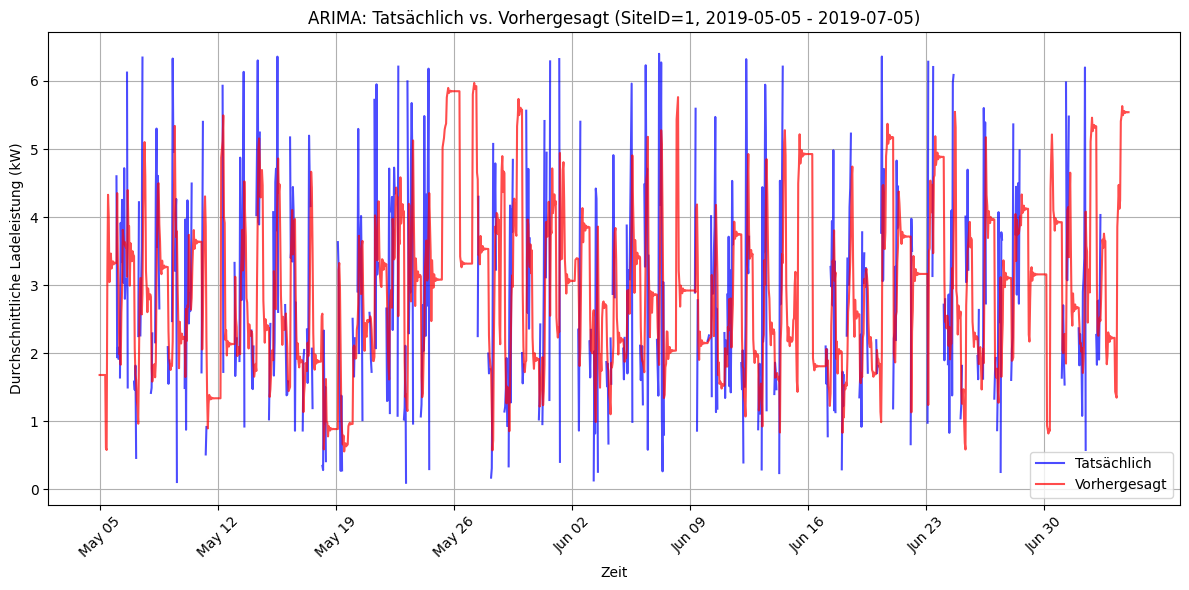

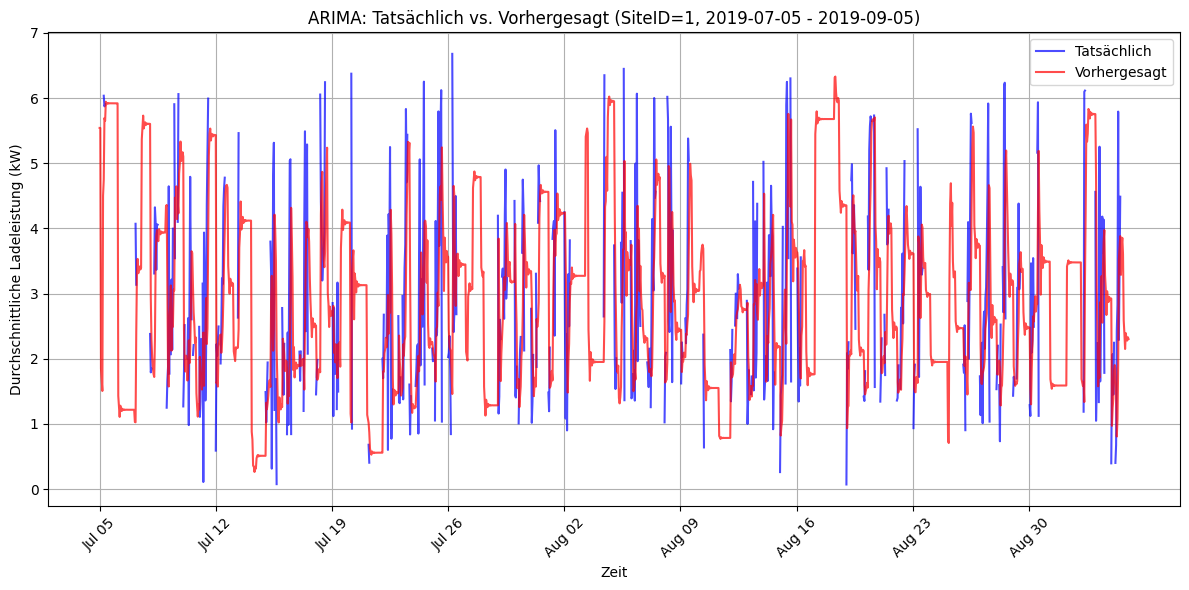

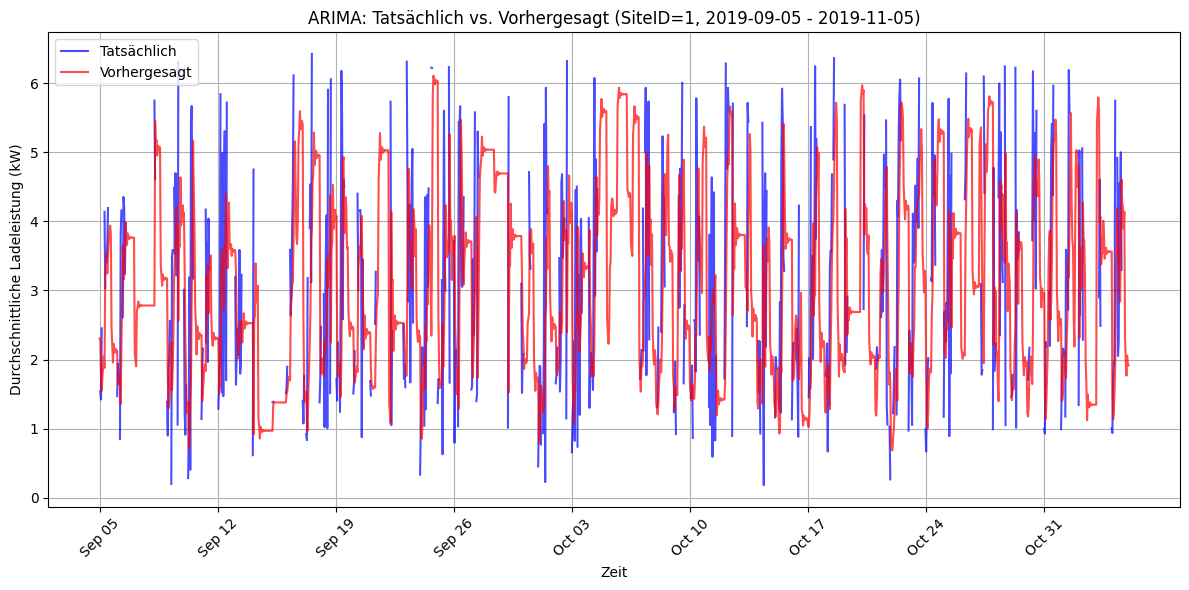

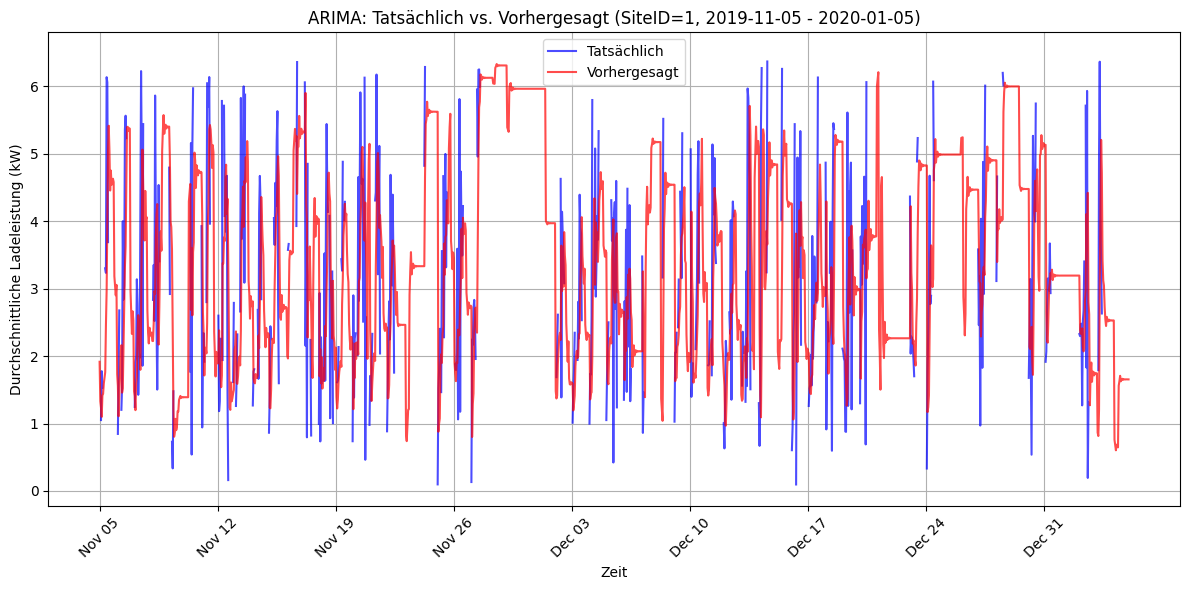

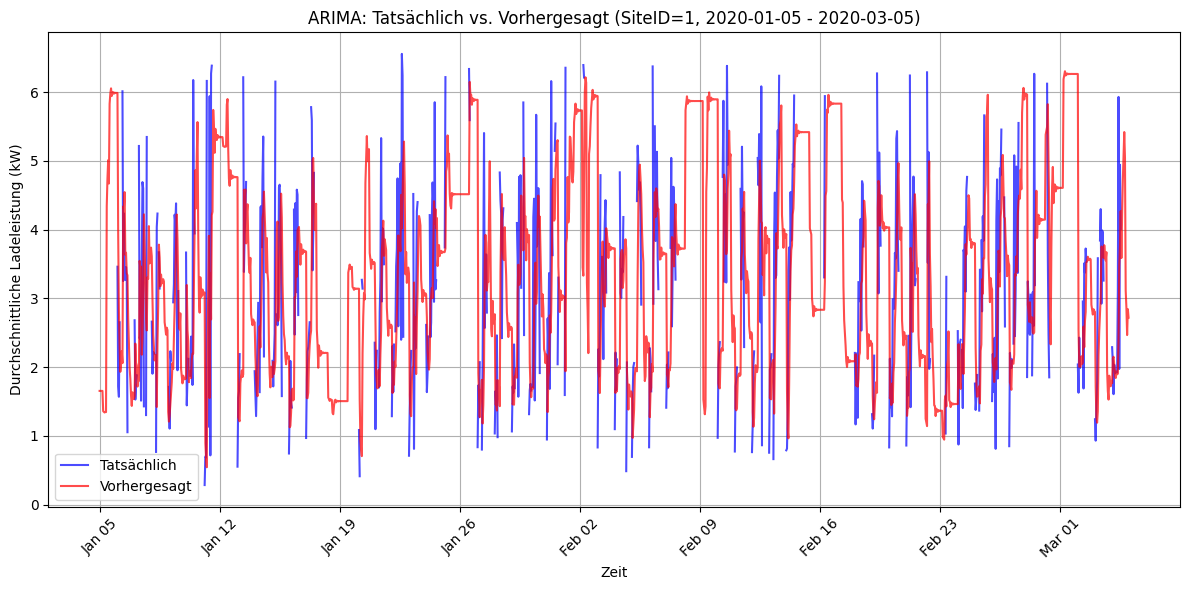

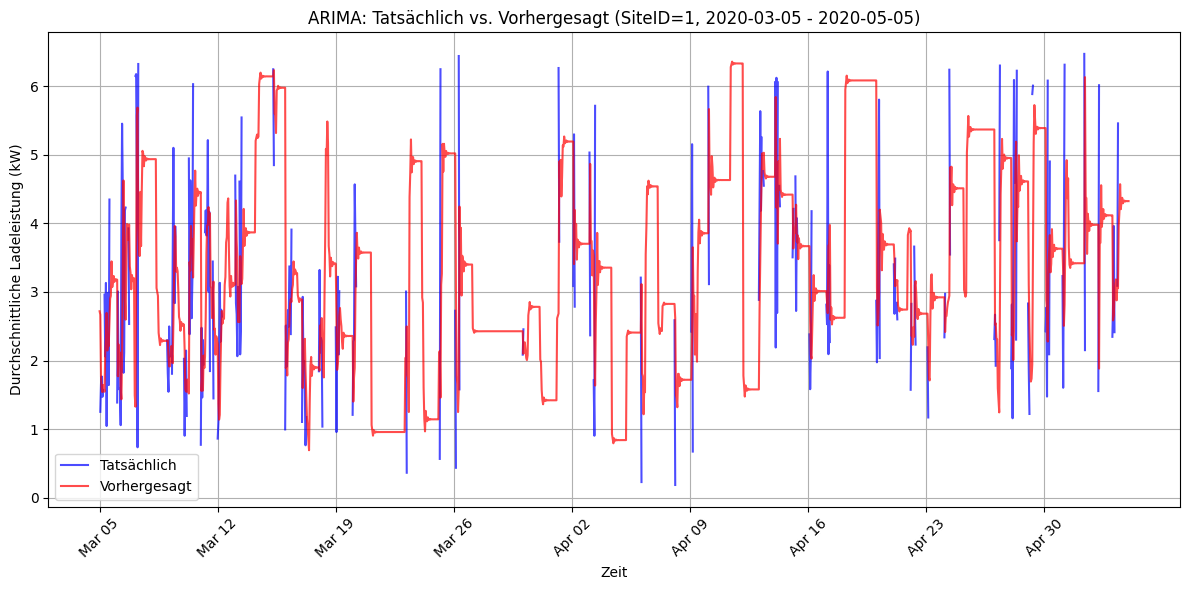

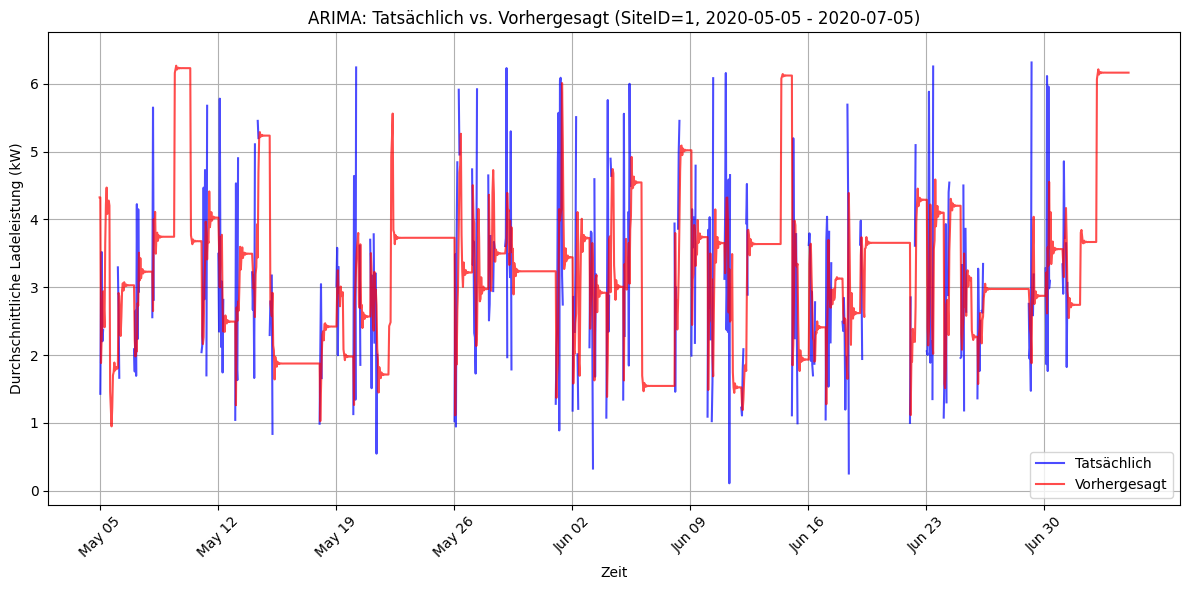

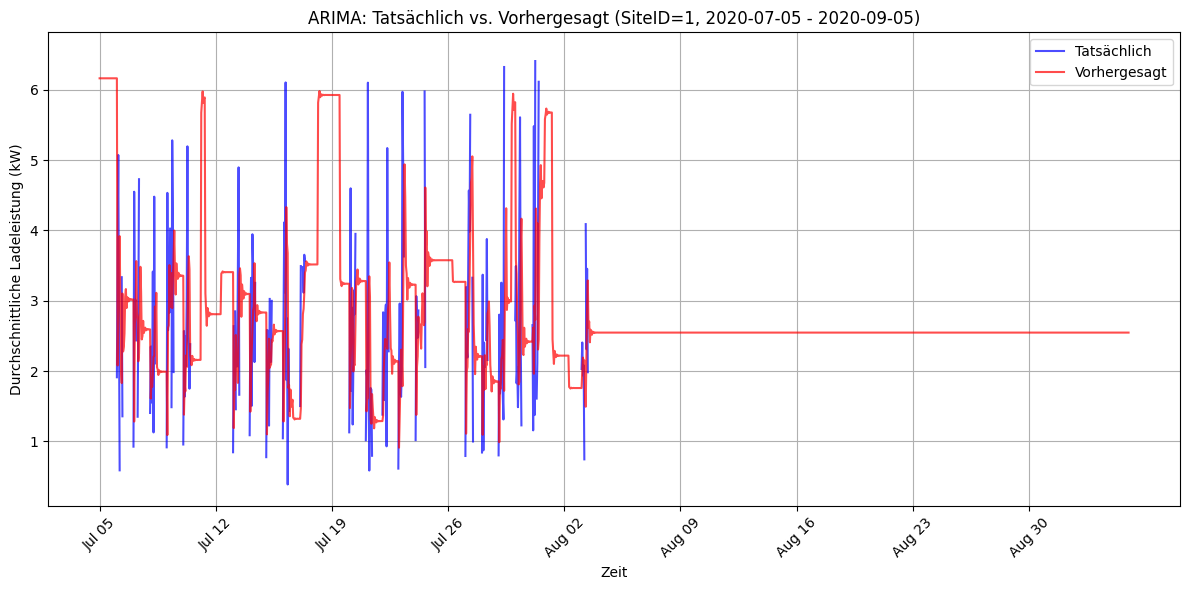

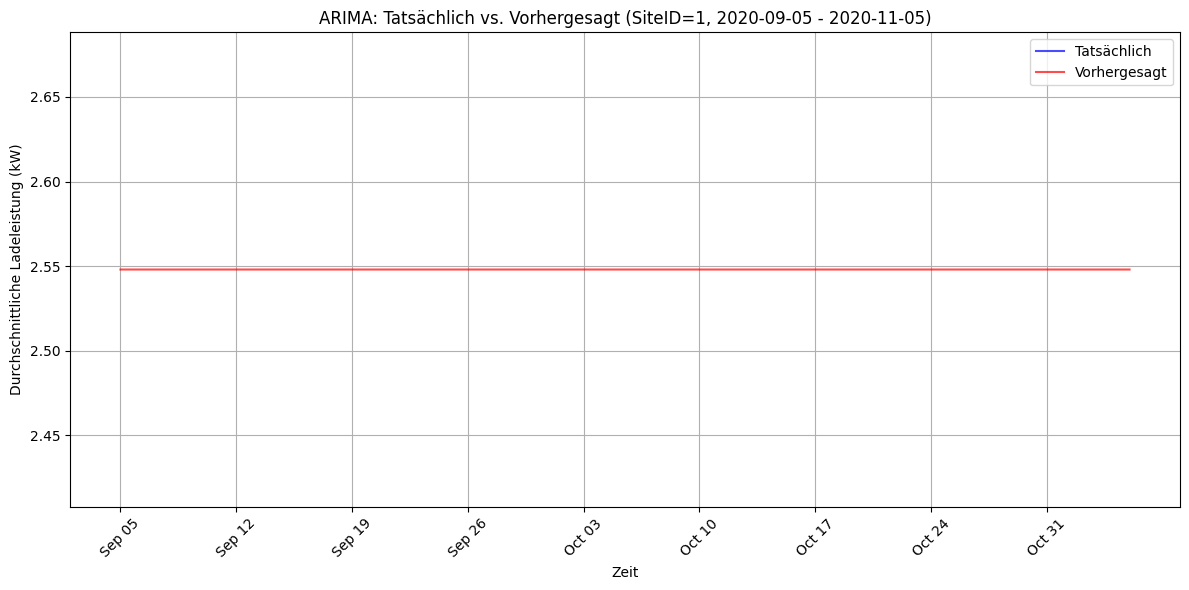

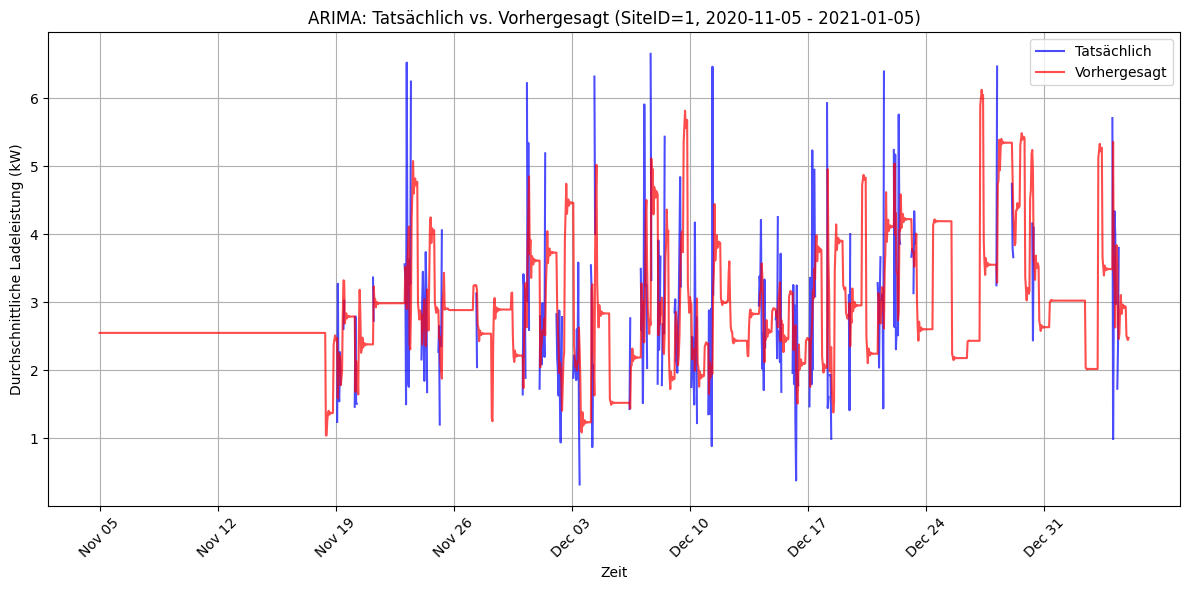

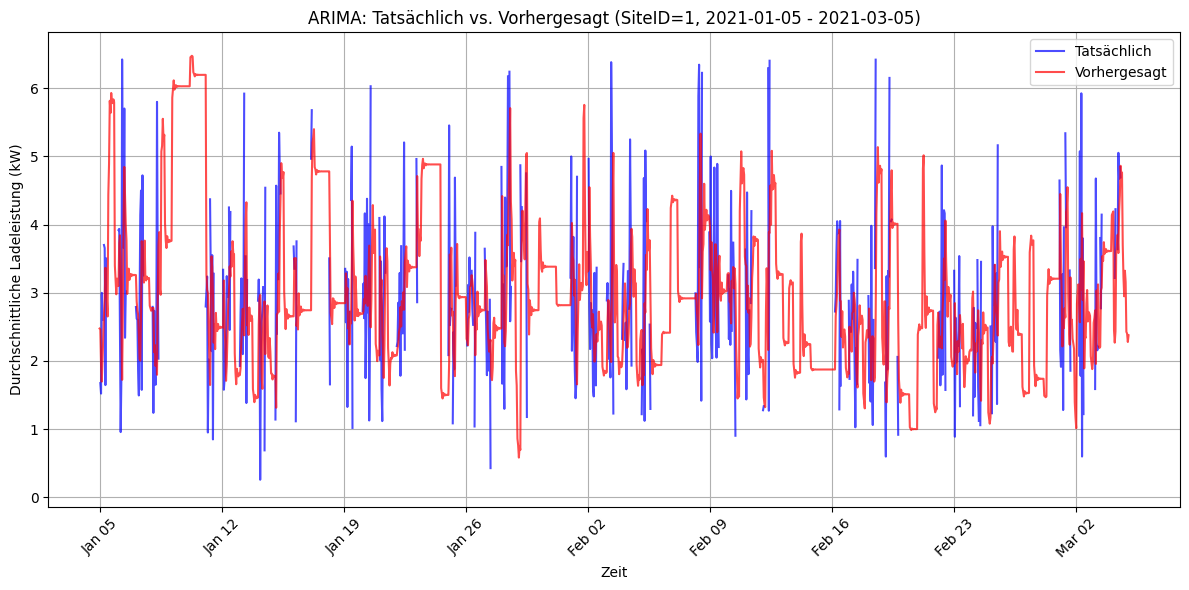

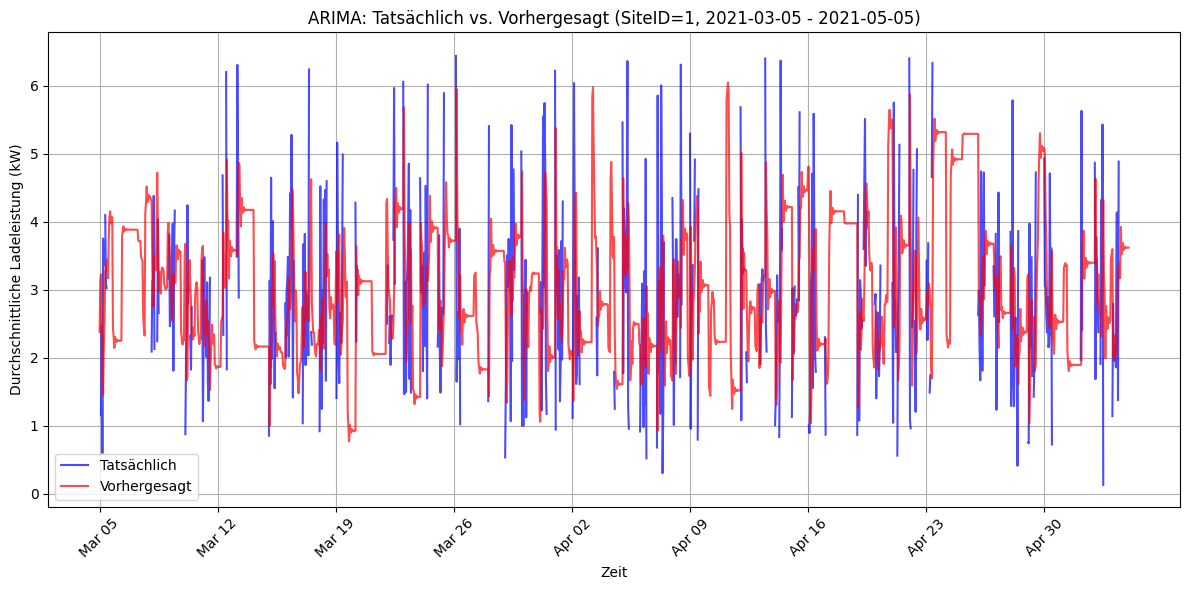

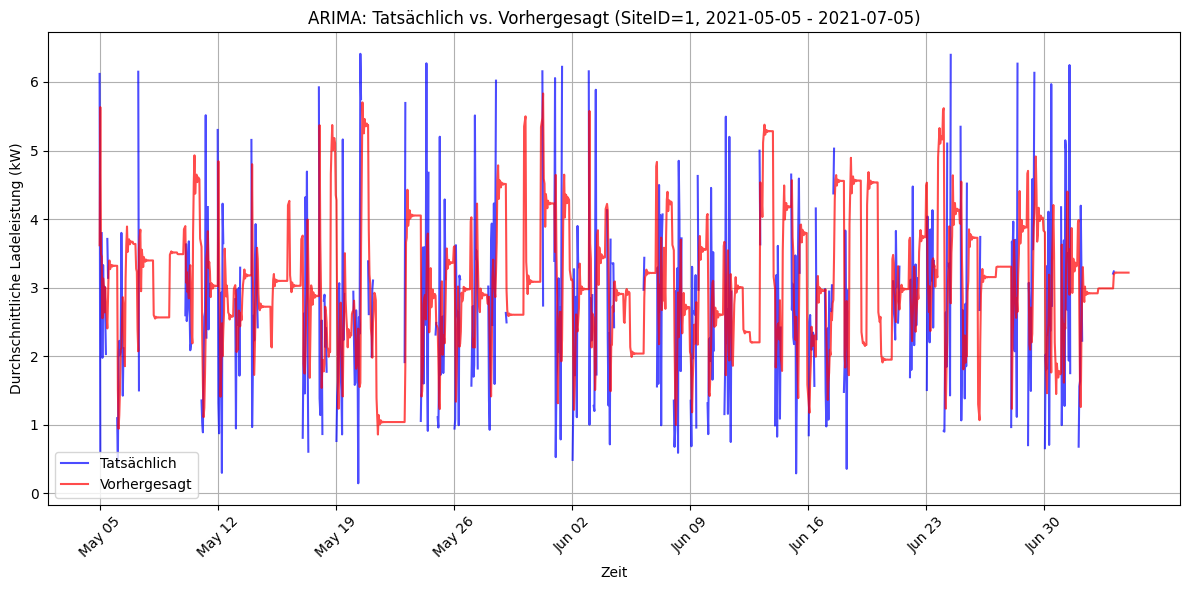

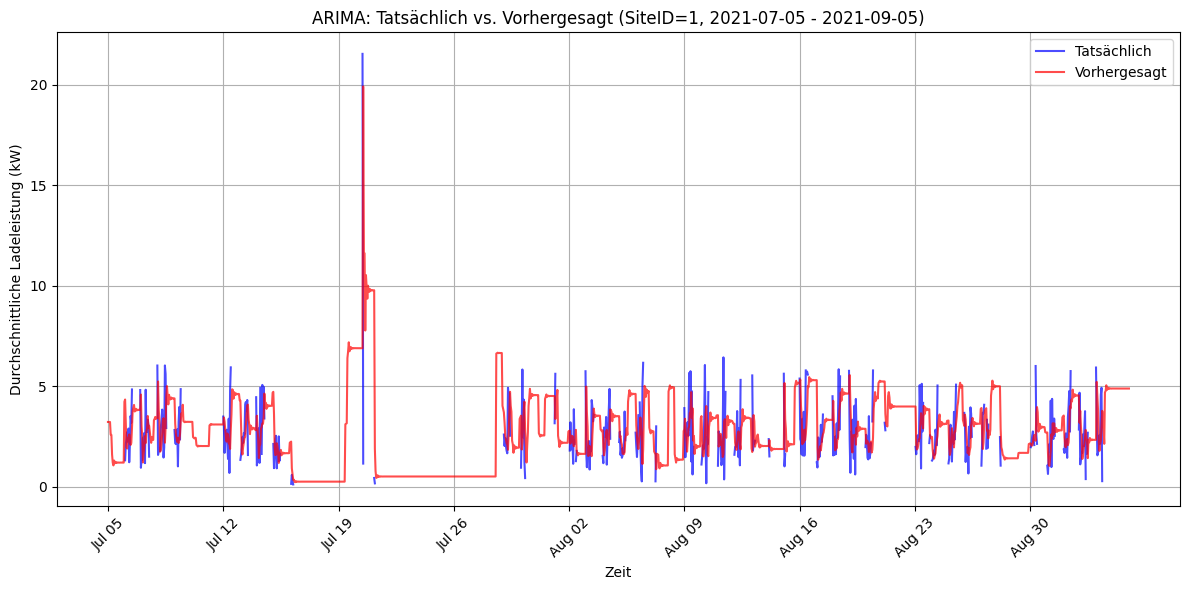

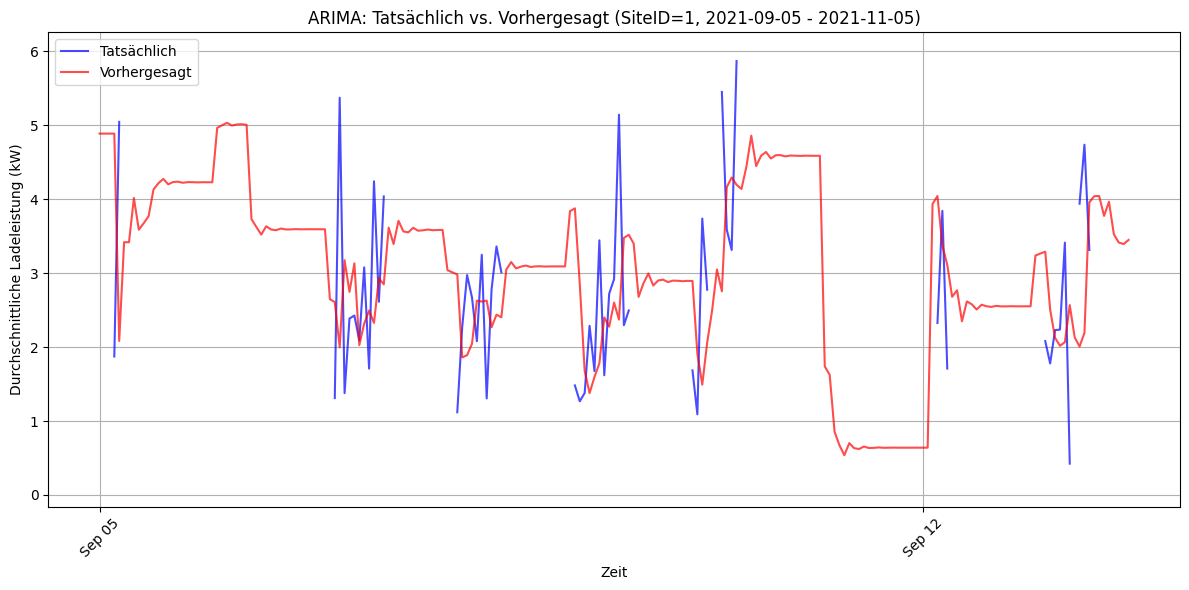


Analyse für SiteID=2


C:\Users\tobia\AppData\Local\Temp\ipykernel_31180\73915192.py:72: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ts = site_data.resample('H', on='connectionTime')['averageChargingPower'].mean()
C:\Users\tobia\AppData\Local\Temp\ipykernel_31180\73915192.py:78: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ts = ts.asfreq('H')
C:\Users\tobia\Documents\GitHub\AnalyticsandApplications\AAEnergizer\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\tobia\Documents\GitHub\AnalyticsandApplications\AAEnergizer\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecast

Durchschnittlicher Fehler für SiteID=2: 4.3754
RSS für averageChargingPower (SiteID=2): nan


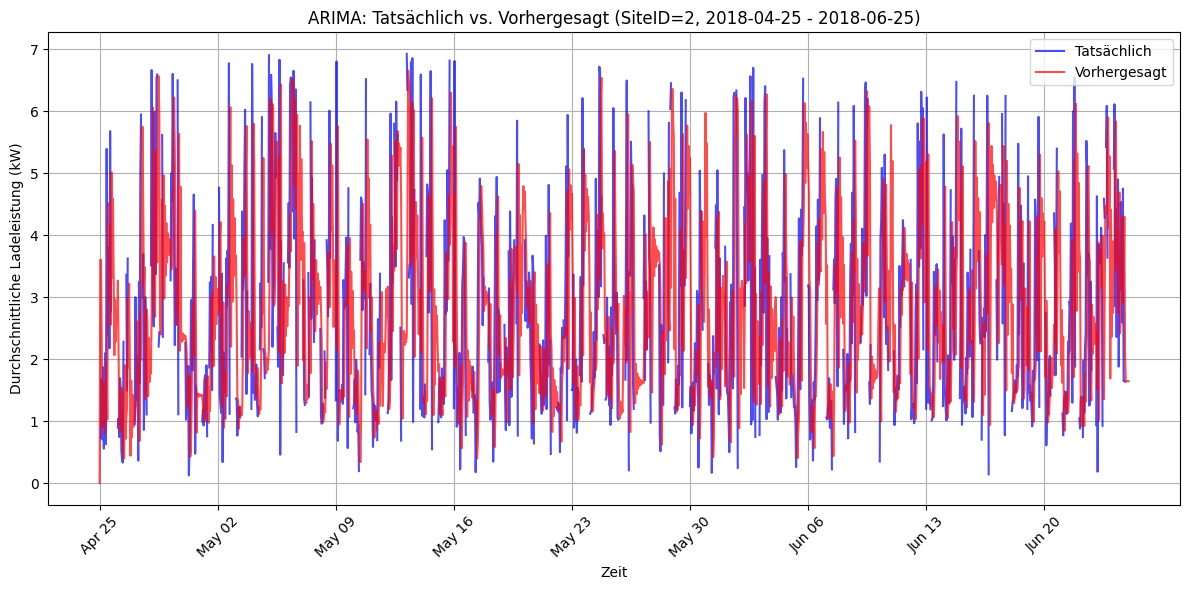

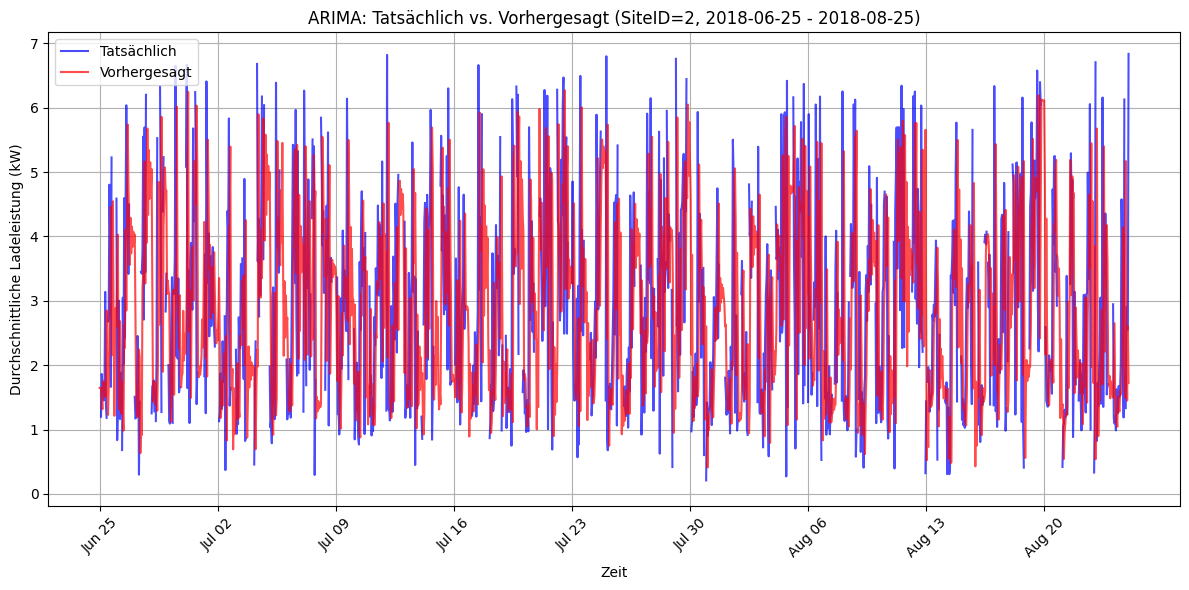

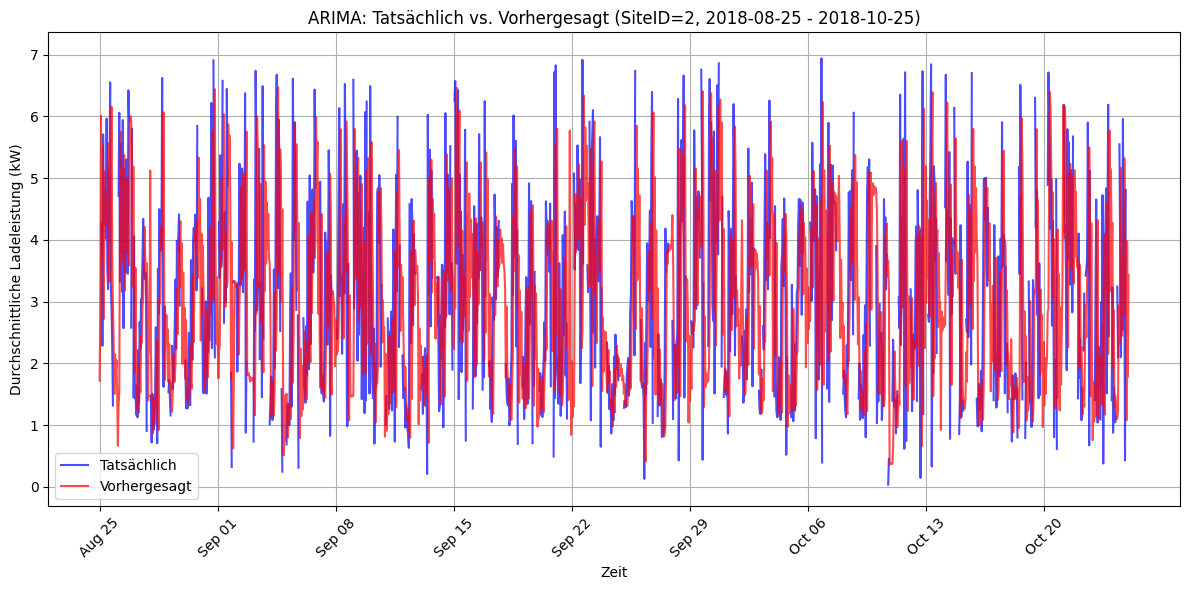

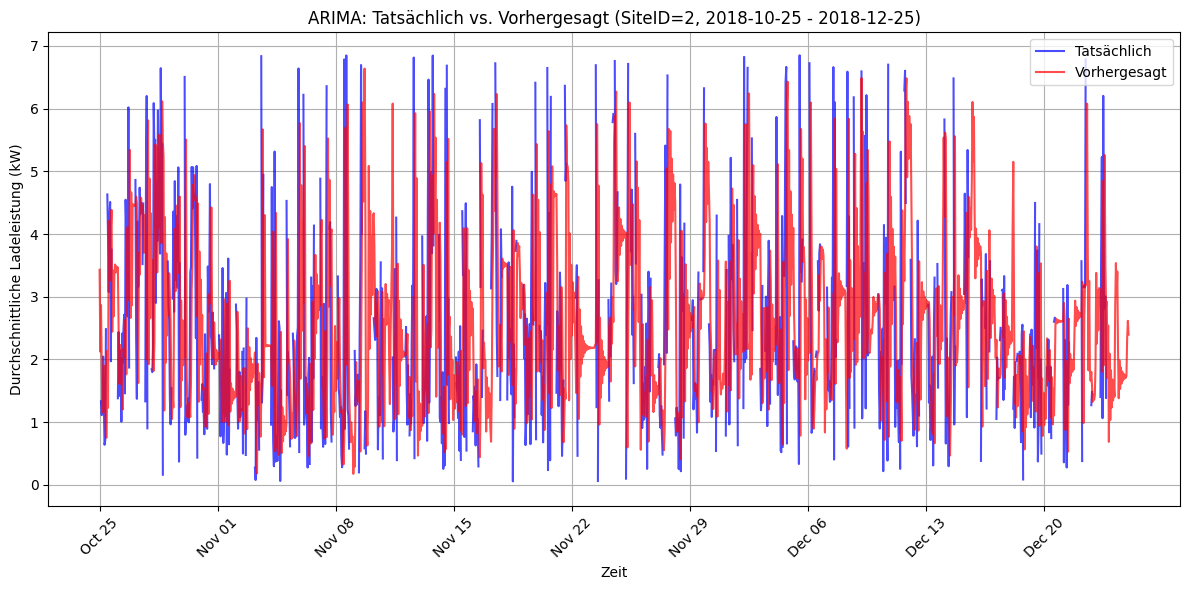

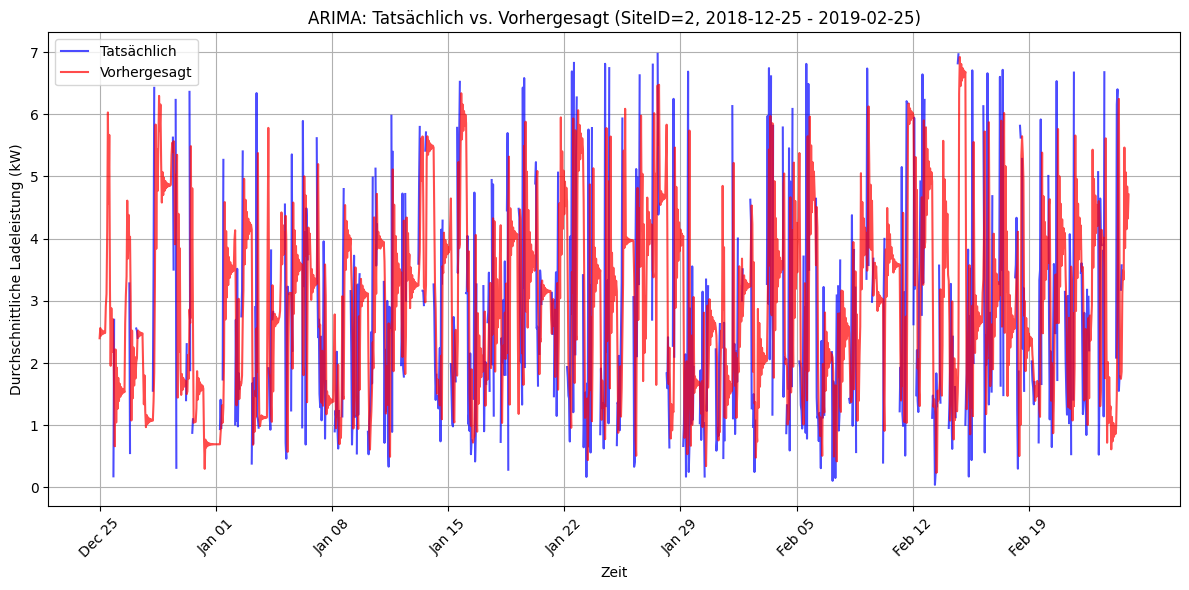

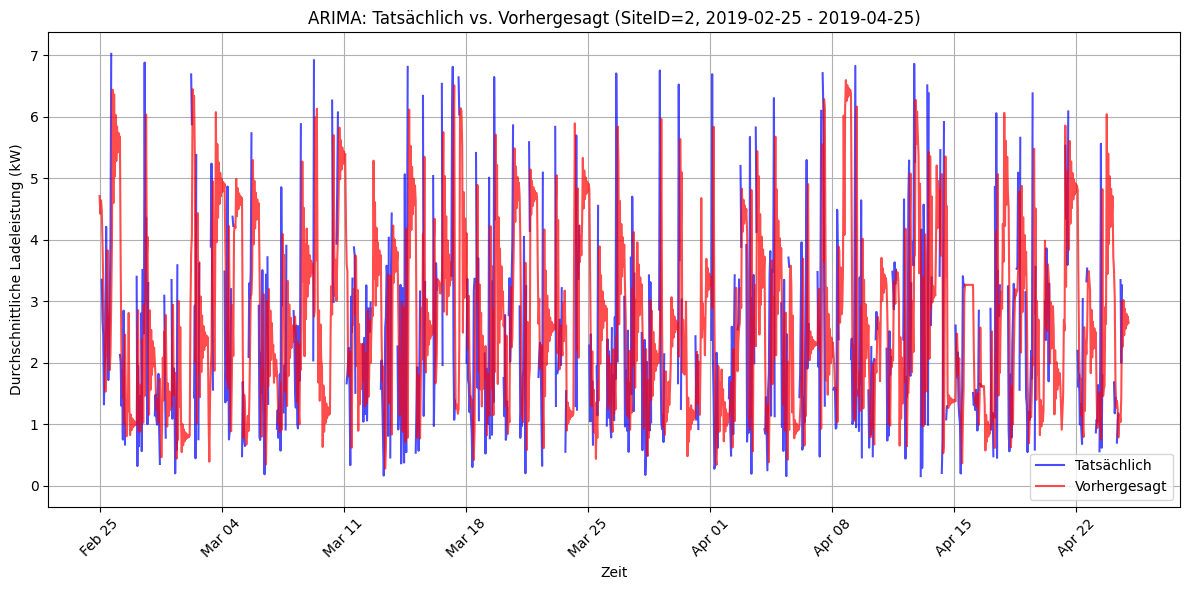

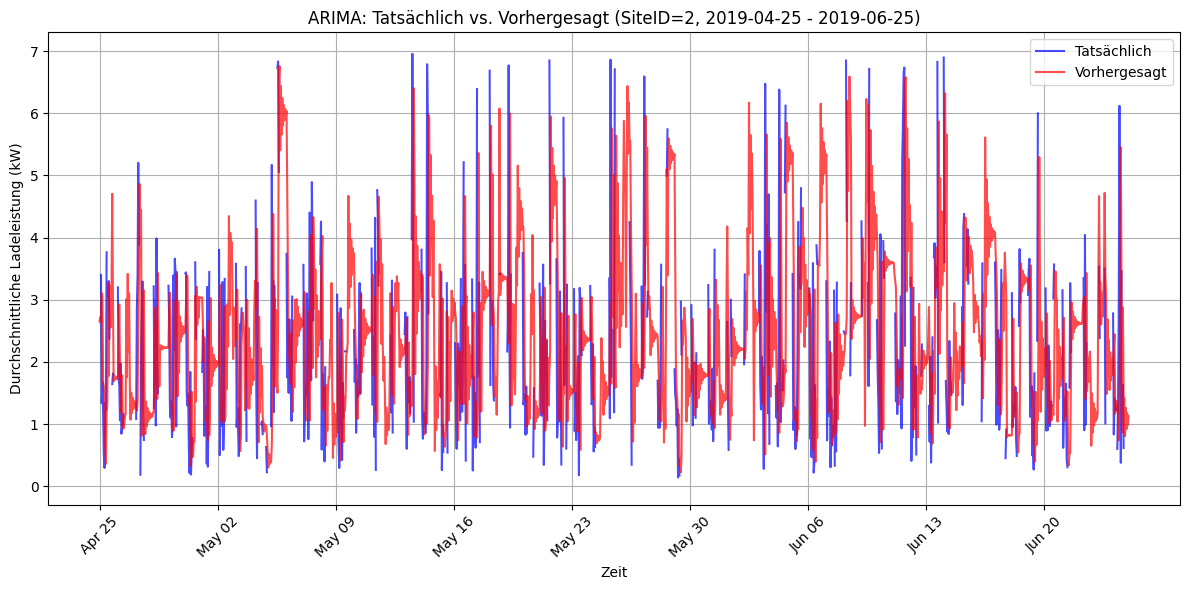

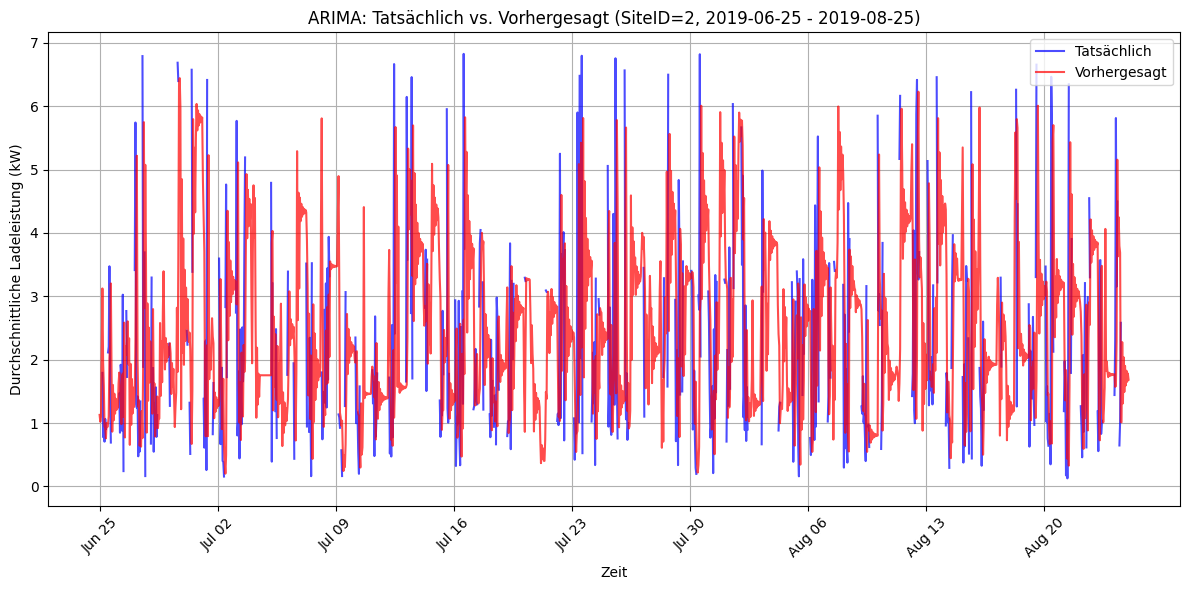

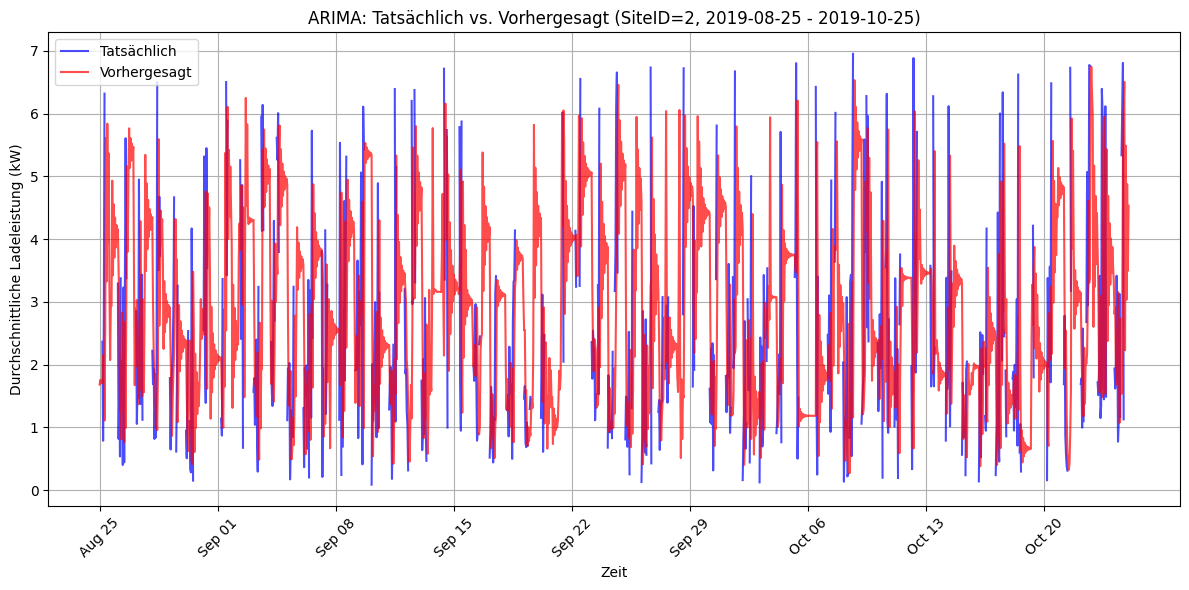

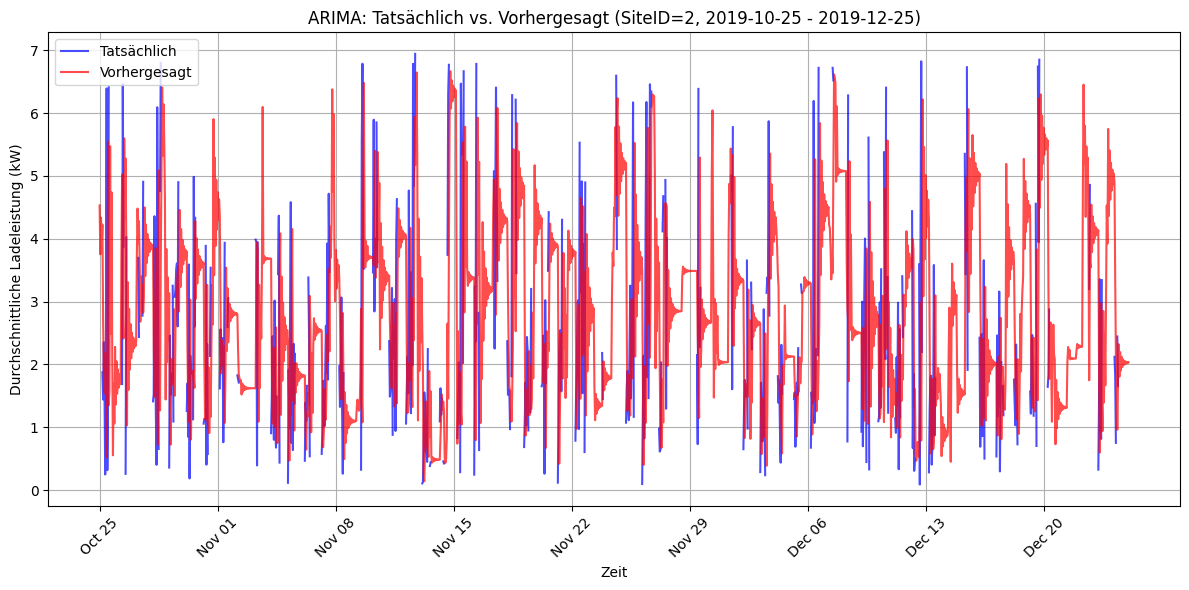

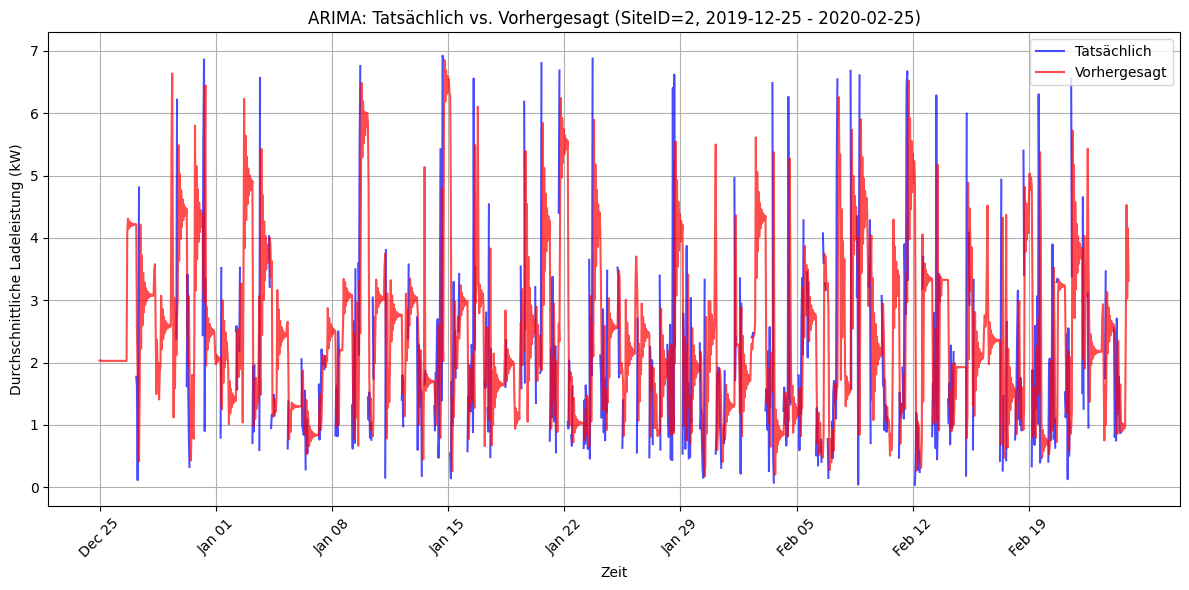

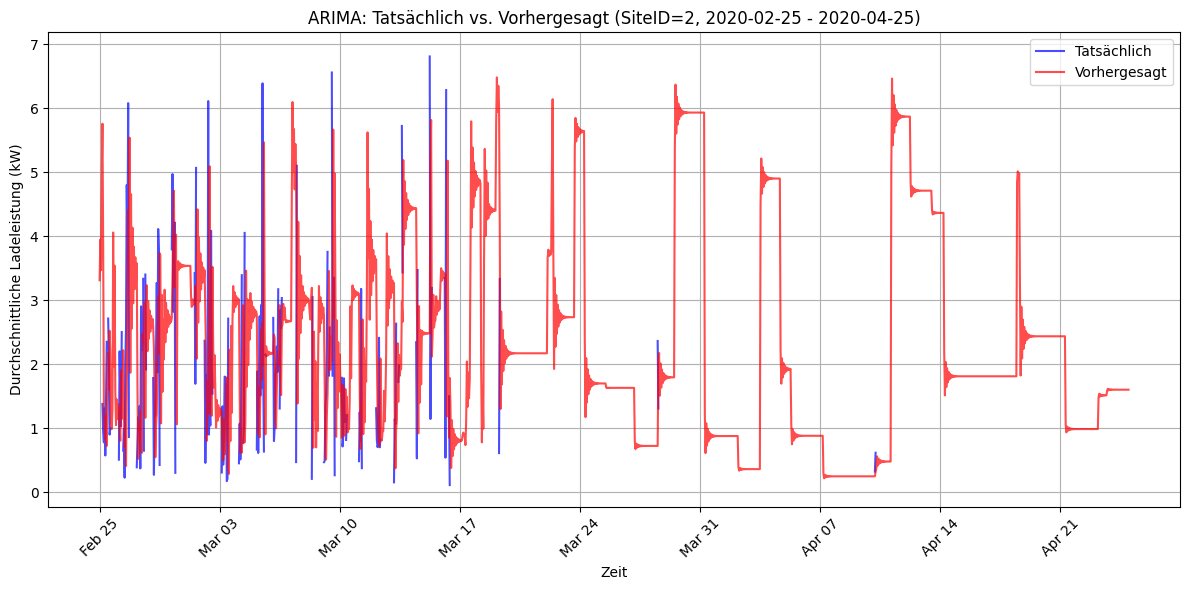

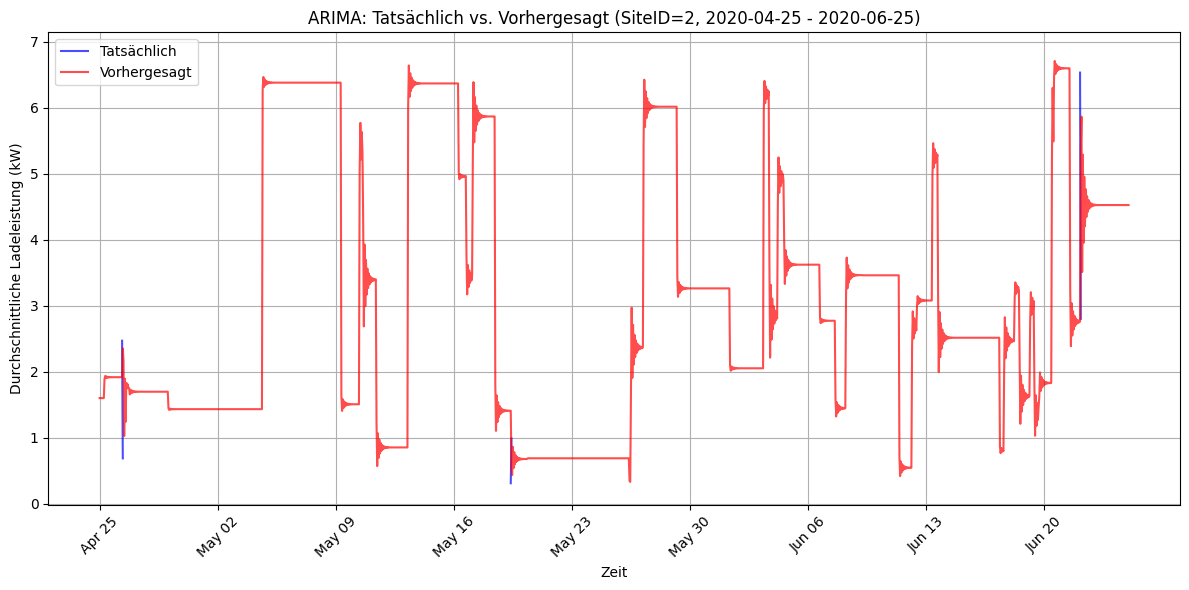

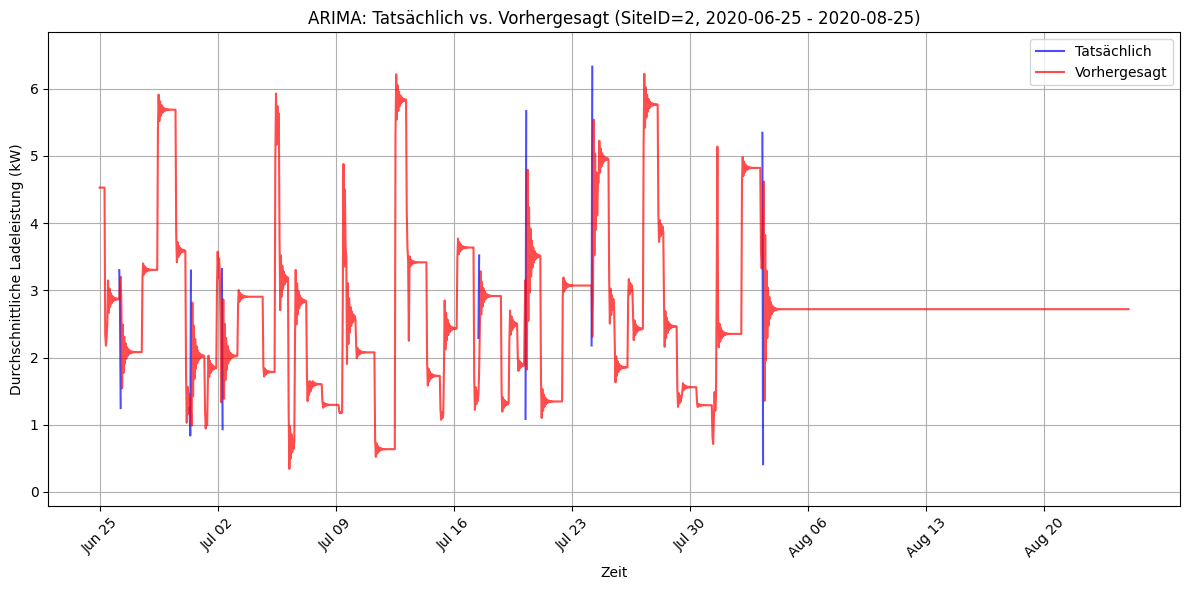

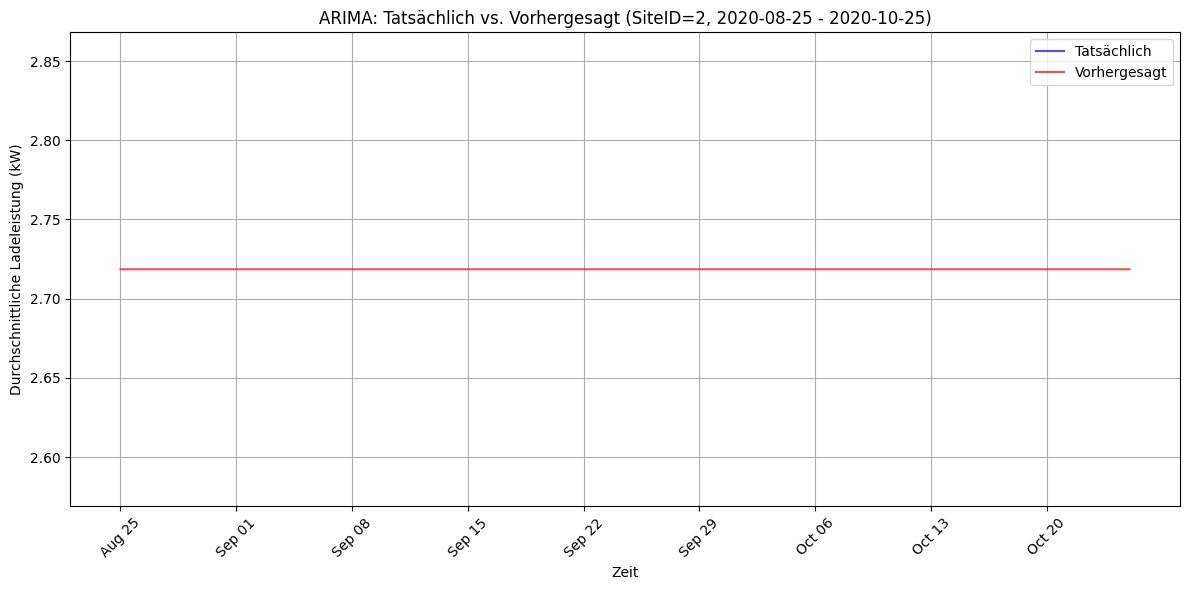

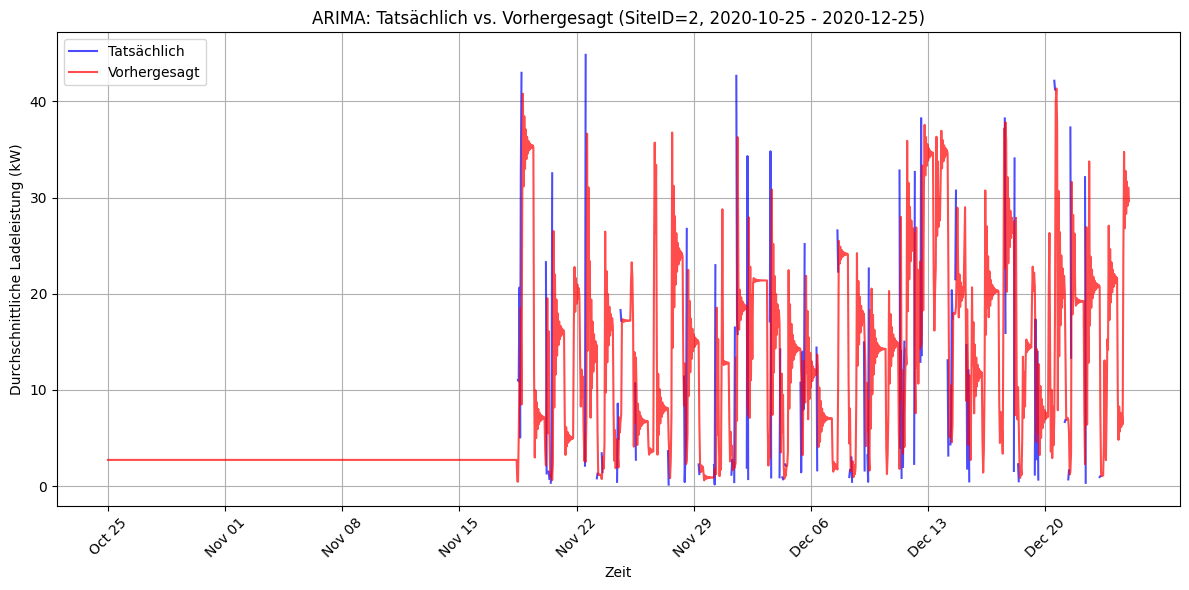

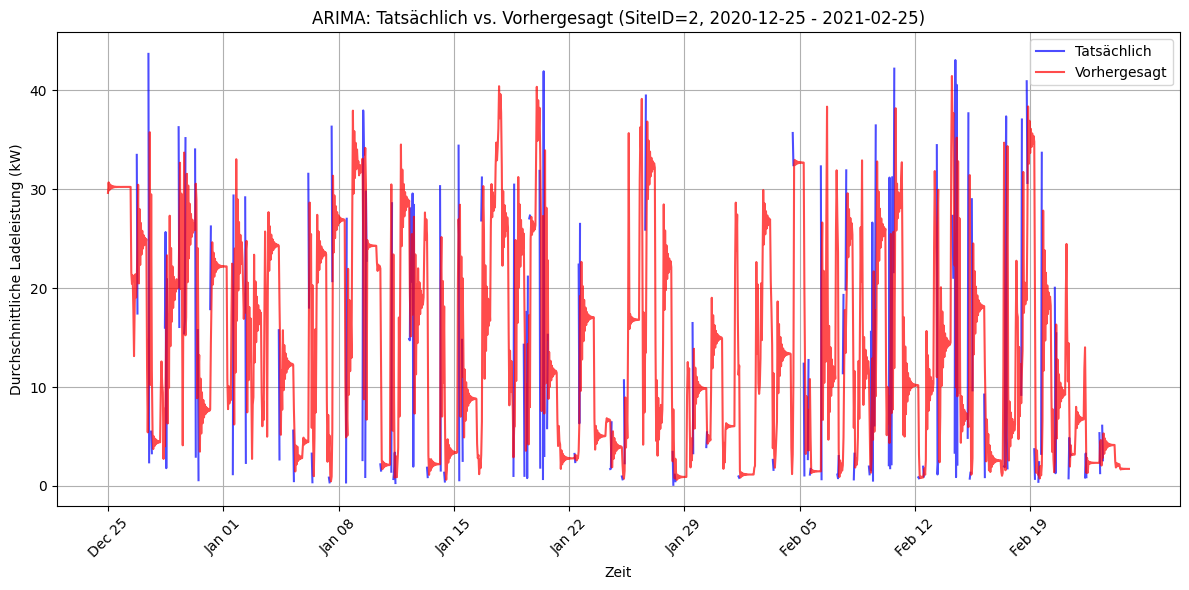

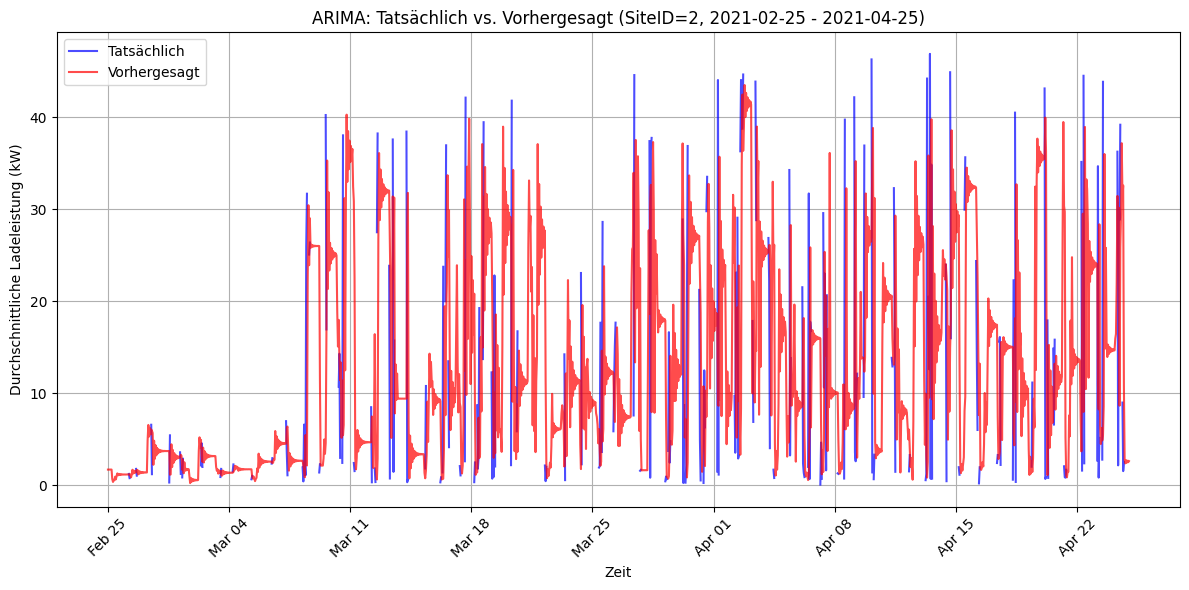

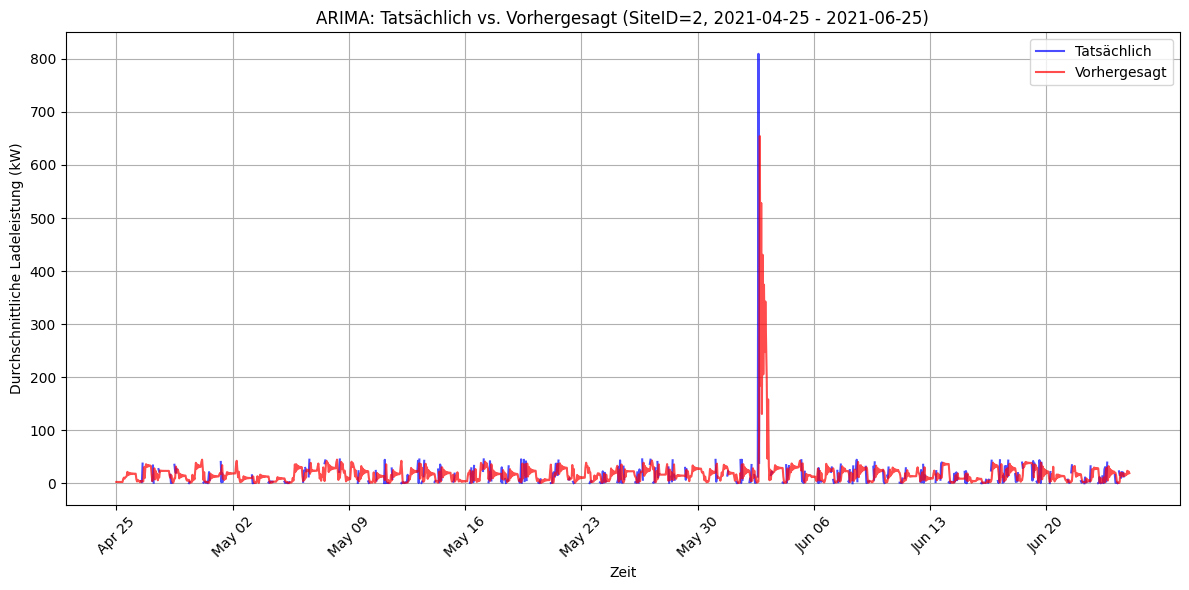

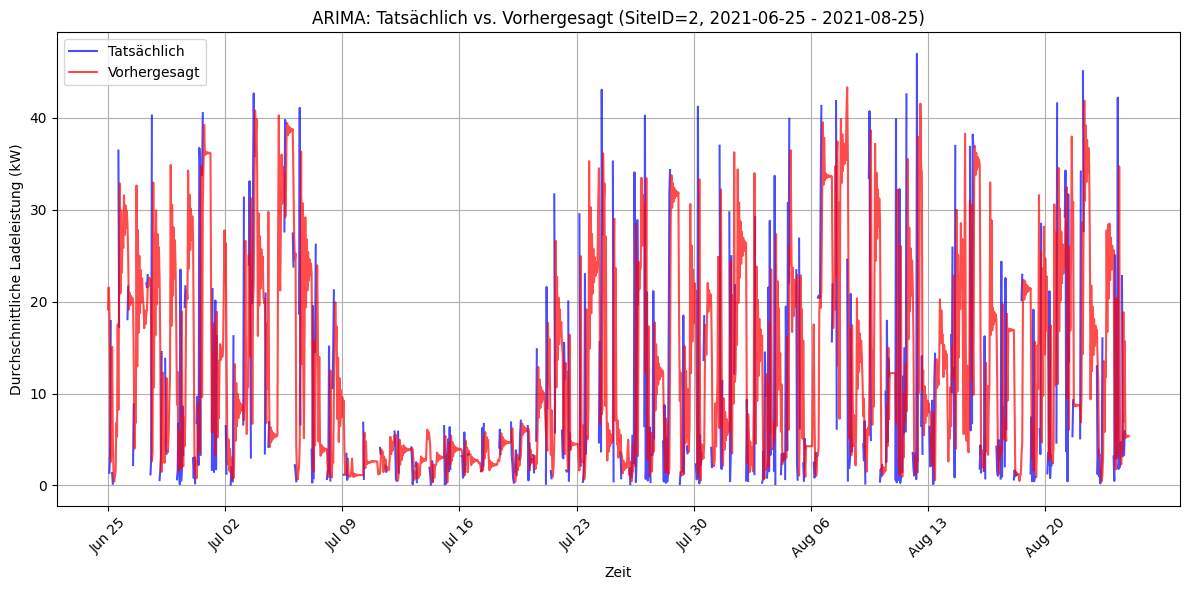

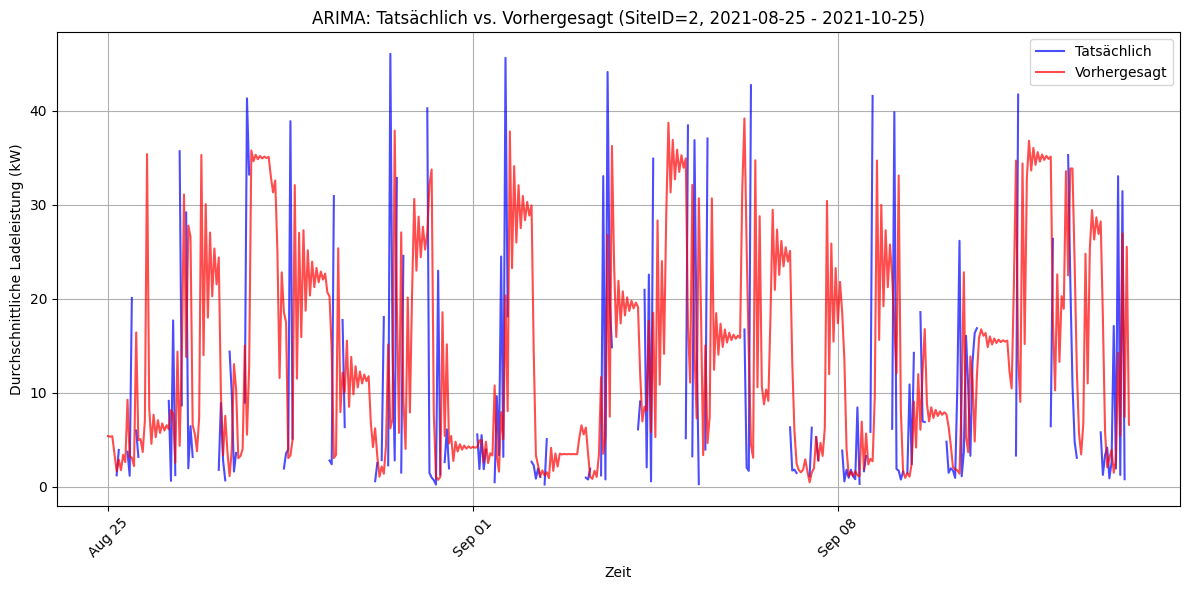

In [33]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# 1. Daten laden
file_path = "../data/processed/charging_sessions_cleaned.csv"
data = pd.read_csv(file_path, parse_dates=["connectionTime", "disconnectTime", "doneChargingTime"])

# 2. Feature-Engineering
# Berechnung der durchschnittlichen Ladeleistung
data['averageChargingPower'] = data['kWhDelivered'] / (
        (data['disconnectTime'] - data['connectionTime']).dt.total_seconds() / 3600
)

# Standortauslastung berechnen
data['connectionStart'] = data['connectionTime'].dt.floor('min')
data['connectionEnd'] = data['disconnectTime'].dt.floor('min')
occupancy = []
for index, row in data.iterrows():
    count = data[
        (data['siteID'] == row['siteID']) &
        (data['connectionTime'] <= row['disconnectTime']) &
        (data['disconnectTime'] >= row['connectionTime'])
    ].shape[0]
    occupancy.append(count)
data['siteOccupancy'] = occupancy

# Nur notwendige Spalten und keine NaN-Werte
data = data[['connectionTime', 'siteID', 'averageChargingPower', 'siteOccupancy']].dropna()

# Cross-Validation: Walk-Forward Methode
def cross_validate(ts, order=(2, 1, 0), months=2):
    # Anzahl der Schritte für Cross-Validation (2 Monate)
    start_date = ts.index.min()
    end_date = ts.index.max()
    current_date = start_date
    errors = []

    while current_date + pd.DateOffset(months=months) <= end_date:
        next_date = current_date + pd.DateOffset(months=months)

        # Trainings- und Testdatensatz
        train = ts[current_date:next_date].dropna()  # Sicherstellen, dass keine NaN-Werte im Training sind
        test = ts[next_date:next_date + pd.DateOffset(months=months)].dropna()  # Testset auch ohne NaN

        if len(test) == 0:  # Wenn das Testset leer ist, abbrechen
            break

        # ARIMA-Modell erstellen und trainieren
        model = ARIMA(train, order=order)
        model_fit = model.fit()

        # Vorhersagen
        y_pred = model_fit.forecast(len(test))

        # Fehlerberechnung (MSE)
        mse = mean_squared_error(test, y_pred)
        errors.append(mse)

        current_date = next_date

    return np.mean(errors)

# Zeitreihenanalyse für SiteID=1 und SiteID=2
for site in [1, 2]:
    print(f"\nAnalyse für SiteID={site}")
    site_data = data[data['siteID'] == site]

    # Zeitreihe: Durchschnittliche Ladeleistung pro Stunde
    ts = site_data.resample('H', on='connectionTime')['averageChargingPower'].mean()

    # NaN-Werte nach dem Resampling entfernen
    ts = ts.dropna()

    # Sicherstellen, dass die Zeitreihe eine klare Frequenz hat
    ts = ts.asfreq('H')

    # Cross-Validation durchführen
    try:
        mean_error = cross_validate(ts, order=(2, 1, 0), months=2)
        print(f"Durchschnittlicher Fehler für SiteID={site}: {mean_error:.4f}")

        # Vorhersagen für das letzte 2-Monats-Fenster
        model = ARIMA(ts, order=(2, 1, 0))
        results_AR = model.fit()

        # Vorhersagen
        y_pred = results_AR.fittedvalues

        # Fehlerberechnung (RSS)
        rss = sum((y_pred - ts) ** 2)
        print(f"RSS für averageChargingPower (SiteID={site}): {rss:.4f}")

        # Zeitreihe in 2-Monats-Abschnitte teilen und plotten
        start_date = ts.index.min()
        end_date = ts.index.max()
        current_date = start_date

        while current_date < end_date:
            next_date = current_date + pd.DateOffset(months=2)

            ts_subset = ts[current_date:next_date]
            y_pred_subset = y_pred[current_date:next_date]

            plt.figure(figsize=(12, 6))
            plt.plot(ts_subset, label="Tatsächlich", color="blue", alpha=0.7)
            plt.plot(y_pred_subset, label="Vorhergesagt", color="red", alpha=0.7)
            plt.title(
                f"ARIMA: Tatsächlich vs. Vorhergesagt (SiteID={site}, {current_date.date()} - {next_date.date()})")
            plt.xlabel("Zeit")
            plt.ylabel("Durchschnittliche Ladeleistung (kW)")

            # X-Achse in 7-Tages-Intervallen beschriften
            ticks = ts_subset.index[::7 * 24]  # 7-Tages-Schritte, 24 Stunden pro Tag
            tick_labels = [date.strftime('%b %d') for date in ticks]
            plt.xticks(ticks, tick_labels, rotation=45)

            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

            current_date = next_date

    except Exception as e:
        print(f"Fehler beim ARIMA-Modell für SiteID={site}: {e}")
